In [5]:
from dengo.chemical_network import ChemicalNetwork, reaction_registry, cooling_registry, species_registry
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import numpy as np
import matplotlib.pyplot as plt
import sympy

In [6]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

In [7]:
from matplotlib.backends.backend_pdf import PdfPages

In [8]:
dengo.primordial_rates.setup_primordial();

In [9]:
primordial = ChemicalNetwork()

In [10]:
for i in range(23):
    n = "k%02i" % (i+1)
    if n in reaction_registry:
        primordial.add_reaction(n)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_2 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [11]:
# Initializing primordial network
NCELLS = 1
density = 1e7
temperature = np.logspace(2, 4, NCELLS)
temperature[:] = 2e3
X = 0.5

primordial.init_temperature((1e0, 1e8))

init_array = np.ones(NCELLS) * density
init_values = dict()
init_values['H_1']   = init_array * 0
init_values['H_2']   = X * init_array
init_values['H_m0']  = init_array * tiny
init_values['He_1']  = init_array * tiny
init_values['He_2']  = init_array * tiny
init_values['He_3']  = init_array * tiny
init_values['H2_1']  = init_array * tiny
init_values['H2_2']  = init_array * tiny
init_values['de']    = init_array * 0.0

total_density = primordial.calculate_total_density(init_values)
init_values["H_1"] = init_array.copy() - total_density
init_values = primordial.convert_to_mass_density(init_values)
init_values['de'] = primordial.calculate_free_electrons(init_values)
init_values['density'] = primordial.calculate_total_density(init_values)
number_density = primordial.calculate_number_density(init_values)

# set up initial temperatures values used to define ge
init_values['T'] = temperature

# calculate ge (very crudely, no H2 help here)
gamma = 5.0/3.0
init_values['ge'] = ((temperature * number_density * kboltz)
                     / (init_values['density'] * mh * (gamma - 1)))

In [12]:
def get_jac_component(species1, species2):
    f_species1 = primordial.species_total(species1)
    df1_f2 = f_species1.diff(species2)
    return df1_f2

#building jacobian with functions as values
def build_jacobian(network):
    rxn_rates = sorted(network.reactions.keys())
    species = sorted(network.species_list())
    f_arguments = species+rxn_rates+['i']
    rxn_jac = np.zeros((len(species),len(species)),dtype=object)
    for j in range(len(species)):
        for k in range(len(species)):
            jac_fn = get_jac_component(species[j],species[k])
            rxn_jac[j][k] = sympy.lambdify(f_arguments,jac_fn,"numpy")
    
    return rxn_jac

# rxn_jac is the matrix of functions for the jacobian terms
# species_rates_list is a list of species values and list of rxn_rate arrays
# temp index is the index for the rxn_rate arrays corresponding to a specific temperature
def compute_jacobian(rxn_jac,species_rates_list,temp_index):
    jac = np.zeros((len(rxn_jac),len(rxn_jac)),dtype=float)
    for j in range(len(jac)):
        for k in range(len(jac)):
            jac[j][k] = rxn_jac[j][k](*species_rates_list,i=temp_index)
    return jac

In [13]:
# Species function computes the rhs of each chemical species
def build_species_function(network):
    rxn_rates = sorted(network.reactions.keys())
    species = sorted(network.species_list())
    f_arguments = species+rxn_rates+['i']
    species_fn = np.zeros(len(species),dtype=object)
    for s in range(len(species)):
        sp_fn = network.species_total(species[s])
        species_fn[s] = sympy.lambdify(f_arguments,sp_fn,"numpy")
    
    return species_fn

def compute_species_function(species_fn,species_rates_list,temp_index):
    sp_fn = np.zeros(len(species_fn),dtype=float)
    for j in range(len(species_fn)):
        sp_fn[j] = species_fn[j](*species_rates_list,i=temp_index)
    return sp_fn

In [14]:
# The objective function is what we're trying to minimize
def objective_function(species_fn,species_rates_list,temp_index):
    obj_fn = np.zeros(len(species_fn),dtype=float)
    for j in range(len(species_fn)):
        obj_fn[j] = 0.5*np.dot(np.transpose(species_fn[j](*species_rates_list,i=temp_index)),species_fn[j](*species_rates_list,i=temp_index))
    return obj_fn

In [108]:
def grad_descent(network, init_values, temp_indices, epsilon, max_step):
    # build jacobian and species function
    rxn_jac = build_jacobian(network)
    species_fn = build_species_function(network)
    
    rxn_rates = sorted(network.reactions.keys())
    species = sorted(network.species_list())
    
    plot_dict = {}
    species_values = []
    for s in species:
        species_values.append(init_values[s][0])
        plot_dict[s] = [init_values[s][0]]
    rate_arrays = []
    for k in range(len(rxn_rates)):
        rate = network.reactions[rxn_rates[k]]
        rate_arrays.append(rate.coeff_fn(network))
    
    # Parameterize species with logs, to keep densities positive
    curr_sp = np.log(species_values)
    
    #learning rate, will make more sophisticated later using a line search algorithm
    gamma = 1.0e7
    
    step = 0
    
    obj_fn_history = []
    
    t_start = time.time()
    while(True): #fix this
        step += 1
        fn_argument = list(curr_sp)+rate_arrays
        curr_jac = compute_jacobian(rxn_jac,fn_argument,temp_indices)
        curr_sp_fn = compute_species_function(species_fn,fn_argument,temp_indices)
        curr_obj = objective_function(species_fn,fn_argument,temp_indices)
        curr_sp = np.array(curr_sp)
        grad_desc_step = np.dot(np.transpose(curr_jac),curr_sp_fn)
        # update species
        curr_sp = curr_sp - gamma*grad_desc_step
        
        for s in range(len(species)):
            plot_dict[species[s]].append(np.exp(curr_sp[s]))
        obj_fn_history.append(np.mean(curr_obj))
        
        fn_argument = list(curr_sp)+rate_arrays
        update_obj = objective_function(species_fn,fn_argument,temp_indices)
        diff = np.mean(np.abs(update_obj-curr_obj))
        
        if(diff<epsilon):
            print("Objective function update difference less than epsilon. Difference=",diff)
            print("Number of steps",step)
            break
        elif(step>max_step):
            print("Max number of steps exceeded.")
            break
    total_time = time.time() - t_start
    print("Average time per gradient descent step:{}".format(total_time))
    return(dict(zip(species,np.exp(curr_sp))),plot_dict,obj_fn_history,gamma)

In [109]:
temp_indices = np.arange(0,len(primordial.T),len(primordial.T)/9)

In [114]:
# inputs to gradient descent function
# epsilon: threshhold difference between updated and old objective function, 
#    returns when difference less than epsilon
# temp_indices: index of temperature value species will be computed at, will fix to be a list 
#    of temperatures
# max_step: cuts off descent after this amount of steps
sp_values = init_values
temp = temp_indices[9]
epsilon = 1e-20
max_step = 100000
sp_values

{'H2_1': array([  2.00000000e-23]),
 'H2_2': array([  2.00000000e-23]),
 'H_1': array([ 5039700.]),
 'H_2': array([ 5039700.]),
 'H_m0': array([  1.00794000e-23]),
 'He_1': array([  4.00260200e-23]),
 'He_2': array([  4.00260200e-23]),
 'He_3': array([  4.00260200e-23]),
 'T': array([ 2000.]),
 'de': array([ 5000000.]),
 'density': array([ 10079400.]),
 'ge': array([  2.45951338e+11])}

In [115]:
eq_species,plot_dict,obj_hist,gamma = grad_descent(primordial,sp_values,temp,epsilon,max_step)

Max number of steps exceeded.
Average time per gradient descent step:78.8092200756


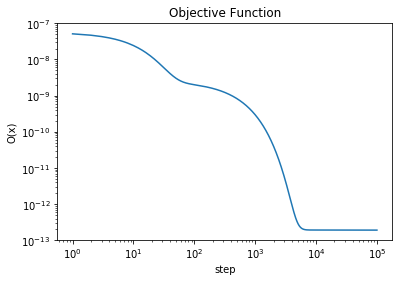

In [116]:
o_x = np.arange(0,len(obj_hist))
plt.loglog(o_x,obj_hist)
plt.title("Objective Function")
plt.xlabel("step")
plt.ylabel("O(x)")

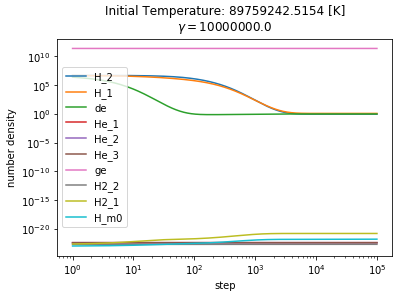

In [117]:
plot_keys = plot_dict.keys()
xs = np.arange(0,len(plot_dict["de"]))
for k in plot_keys:
    plt.loglog(xs,plot_dict[k],label=k)
plt.legend()
plt.xlabel("step")
plt.ylabel("number density")
plt.title("Initial Temperature: {:3} [K]\n".format(primordial.T[temp])+r'$\gamma=$'+str(gamma))
plt.savefig("temp{}".format(temp),dpi=500)

In [ ]:
# temp_indices = np.arange(0,len(primordial.T),len(primordial.T)/9)
# pp = PdfPages('GDruns.pdf')
# for temp in temp_indices:
#     eq_species,plot_dict,obj_hist = grad_descent(primordial,sp_values,temp,epsilon,max_step)
#     plot_keys = plot_dict.keys()
#     xs = np.arange(0,len(plot_dict["de"]))
#     for k in plot_keys:
#         plt.loglog(xs,plot_dict[k],label=k)
#     plt.legend()
#     plt.xlabel("step")
#     plt.ylabel("number density")
#     plt.title("Initial Temperature: {} [K]".format(primordial.T[temp_indices]))
#     pp.savefig()
#     plt.close()
# pp.close